# Clustering Analysis of Distribution Feeders (with Interactive Visualization)

In [10]:
!pip install -U chart-studio

     |████████████████████████████████| 64 kB 1.1 MB/s eta 0:00:01
  Using cached requests-2.25.0-py2.py3-none-any.whl (61 kB)
  Using cached chardet-3.0.4-py2.py3-none-any.whl (133 kB)
  Using cached idna-2.10-py2.py3-none-any.whl (58 kB)
  Using cached urllib3-1.26.2-py2.py3-none-any.whl (136 kB)


In [3]:
import numpy as np
import pprint

# scikit-learn
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_samples, silhouette_score
from sklearn import preprocessing
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA

# SciPy
from scipy.spatial.distance import cdist

# matplotlib
import matplotlib.pyplot as plt
import matplotlib.cm as cm
from mpl_toolkits.mplot3d import Axes3D
%matplotlib inline

# plotly
from plotly import __version__
import chart_studio.plotly.plotly as py


# cufflinks
import cufflinks as cf
cf.go_offline()

#pandas
import pandas as pd
from pandas.plotting import scatter_matrix, parallel_coordinates

from ipywidgets import interactive, fixed, interact, FloatSlider 
print(__doc__)
import datetime
now = datetime.datetime.now()
dtname = now.strftime("%Y%m%d")

Automatically created module for IPython interactive environment


In [4]:
df = pd.read_csv("sample_feeder_data"+".csv" ,sep=",",header=0,low_memory=False)
df = df.set_index('CIRCUIT') 
features = list(df.columns)
indexid = list(df.index)
print(df.shape)
df.head()

(766, 6)


,total_length_mi,PRIMARY_ohms_per_mi,FEEDER_total_ohms,xfmr_per_mi,day_1pctl_v_pk_net_PV_2014,pk_vs_rating_net_PV_2014_capped
CIRCUIT,,,,,,
111,6.766856,2.869198,0.451936,19.063506,0.255361,1.282902
112,6.546780,2.898894,0.990615,14.358203,0.000762,1.199297
113,3.777083,1.790143,0.703049,18.797573,0.335160,0.498880
114,2.721970,2.398333,0.283352,28.288338,0.236970,0.705223
115,6.778030,3.339929,1.047358,11.950374,0.190261,0.585628


In [5]:
df.iplot()

### Principal Component Analysisand its projection to 3D

        1. First standardizing the dataframe.

In [6]:
x = df.values[:,:]
ndim = len(x[0,:])
nsamp = len(x[:,0])
x = StandardScaler().fit_transform(x)
df_std = pd.DataFrame(data = x, columns = features, index=indexid).head()
df_std.head()

,total_length_mi,PRIMARY_ohms_per_mi,FEEDER_total_ohms,xfmr_per_mi,day_1pctl_v_pk_net_PV_2014,pk_vs_rating_net_PV_2014_capped
111,0.951048,0.771691,-0.085939,0.185927,0.385055,1.698713
112,0.853816,0.806956,1.700435,-0.480833,-1.994540,1.413227
113,-0.369866,-0.509738,0.746805,0.148243,1.130886,-0.978493
114,-0.836027,0.212516,-0.644996,1.493123,0.213166,-0.273892
115,0.955985,1.330706,1.888606,-0.822032,-0.223404,-0.682276


In [7]:
pca = PCA(n_components=3)
principalComponents = pca.fit_transform(x)

In [8]:
principalDF = pd.DataFrame(data = principalComponents,columns = ['Princi_Comp_0','Princi_Comp_1','Princi_Comp_2'])
principalDF.head()

,Princi_Comp_0,Princi_Comp_1,Princi_Comp_2
0,-1.530944,-0.996348,0.609102
1,-2.536408,-0.312736,-1.872874
2,0.729417,1.015378,0.862583
3,1.200213,-1.252881,0.447867
4,-1.898874,1.053618,0.045784


In [9]:
# The explained variance tells us how much information (variance) can be attributed to each of the principal components.
pca_score = pca.explained_variance_ratio_
V = pca.components_

In [10]:
pca_score # for this dataset, scores are summing up to 0.778, which means the first 3 components do not contain full information

array([0.4083405 , 0.1982195 , 0.17189908])

In [11]:
# defining local function for 3-D scatter plot
def scatter_3D(A, elevation=30, azimuth=120):
    
    maxpts=1000
    fig = plt.figure(1, figsize=(9, 9))
    ax = Axes3D(fig, rect=[0, 0, .95, 1], elev=elevation, azim=azimuth)
    ax.set_xlabel('component 0')
    ax.set_ylabel('component 1')
    ax.set_zlabel('component 2')

    # plot subset of points
    rndpts = np.sort(np.random.choice(A.shape[0], min(maxpts,A.shape[0]), replace=False))
    coloridx = np.unique(A.iloc[rndpts]['FEEDER_total_ohms'], return_inverse=True)
    colors = coloridx[1] / len(coloridx[0])   
    
    sp = ax.scatter(A.iloc[rndpts,0], A.iloc[rndpts,1], A.iloc[rndpts,2]
               ,c=colors, cmap="jet", marker='o', alpha=0.6
               ,s=50, linewidths=0.8, edgecolor='#BBBBBB')

    plt.show()

In [12]:
principalDF['FEEDER_total_ohms'] = df['FEEDER_total_ohms']
interactive(scatter_3D, A=fixed(principalDF), elevation=30, azimuth=120)

interactive(children=(IntSlider(value=30, description='elevation', max=90, min=-30), IntSlider(value=120, desc…

In [13]:
# scaling data
X = df.values[:,1:]
ndim = len(X[0,:])
nsamp = len(X[:,0])
X = preprocessing.scale(X)
range_k = range(7,8,1)
k=7


# defining customer lambda function for L2 norm calculation
L2norm = lambda x: np.sqrt(np.sum(np.multiply(x,x),axis=1))

In [14]:
kmetric_labels = {'inertia':'Inertia\n(lower is tighter)', 
            'dunn': 'Dunn score\n(higher is better, prone to noise and outliers)', 
            'db': 'Davies-Bouldin score\n(lower is better, worst-case measure)', 
            'silhouette': 'Average silhouette score\n(higher is more compact and separate)',
            'ch': 'Calinski-Harabasz score\n(higher is better)',
            'ss': 'Sum of Squares\n(lower is better)'}
kmetric_col = list(kmetric_labels)
kmetric_col.append('k')
all_kmetric = pd.DataFrame(data = np.vstack((np.zeros(shape=(len(kmetric_col)-1,len(range_k))),range_k)).T, 
                           columns = kmetric_col)
all_kmetric = all_kmetric.set_index('k')
all_labels = pd.DataFrame(data = df.index)

In [15]:
# CLUSTERING
"""
Steps:
1. Initializing the clusterer with k value (and a random generator)
2. fitting the model on the dataset (X)
3. prediction of the labels (i.e. cluster number k) for reach sample/observation
"""

clusterer = KMeans(n_clusters=k, init='k-means++', n_init=100, max_iter=10000, random_state=10)
KM = clusterer.fit(X)
cluster_centers = KM.cluster_centers_
cluster_labels = KM.predict(X)
all_labels['Cluster for k = ' + str(k)] = cluster_labels


"""
1. transform data to a cluster-distance space.
2. calculation of intracluster and intracluster distance using L2norm distance 
3. calculation of the distance between the centers of different cluster  
4. calculation of WCSS (within cluster sum of squares) and of BCSS (between cluster sum of squares)
5. calcuation of other evaluation metrics: inertia, Dunn, 'Davies-Bouldin score, silhouette,
    Calinski-Harabasz score,  Sum of Squares
"""    

x_dk = X - cluster_centers[cluster_labels]
x_k = KM.transform(X)                   
intracluster_d = L2norm(x_dk)
all_labels['L2 from centroid for k = ' + str(k)] = intracluster_d
intercenter_d = cdist(cluster_centers, cluster_centers, 'euclidean')
intercluster_d = L2norm(x_k)


# WCSS Scatter Matrix
WCSM = np.zeros(shape=(ndim,ndim))
for xidx in range(0,nsamp):
    WCSM += np.mat(x_dk[xidx]).T * np.mat(x_dk[xidx])

# BCSS Scatter Matrix
BCSM = np.zeros(shape=(ndim,ndim))
mu = np.mean(X, axis = 0)
for cidx in range(0,k):
    BCSM += sum(cluster_labels==cidx) * np.mat(cluster_centers[cidx]-mu).T * np.mat(cluster_centers[cidx]-mu)



### inertia            
all_kmetric['inertia'].loc[k] = KM.inertia_

### Dunn
all_kmetric['dunn'].loc[k] = np.sqrt(intercenter_d[intercenter_d!=0].min()) / np.sqrt(intracluster_d.max())

### Davies-Bouldine
R = np.zeros(shape=(k,))
for ci in range(0,k):
    for cj in range(0,k):
        S_i = intracluster_d[cluster_labels==ci].mean()
        S_j = intracluster_d[cluster_labels==cj].mean()
        R_ij = np.zeros(shape=(k,k))
        R_ij[ci,cj] = (S_i + S_j) / intercenter_d[ci,cj]
        R[ci] = R_ij[R_ij != np.inf].max()
all_kmetric['db'].loc[k] = 1 / float(k) * R.sum()


### ch            
all_kmetric['ch'].loc[k] = np.trace(BCSM) / np.trace(WCSM) * float((nsamp - k) / (k - 1))

### ss            
all_kmetric['ss'].loc[k] = np.trace(WCSM) / np.trace(BCSM) * float(k)

"""
The silhouette_score gives the average value for all the samples.
This gives a perspective into the density and separation of the formed clusters

"""
silhouette_avg = silhouette_score(X, cluster_labels)
print("For k =", k,
    "The average silhouette score is :", silhouette_avg)
all_kmetric['silhouette'].loc[k] = silhouette_avg

For k = 7 The average silhouette score is : 0.200190303055267


/home/sakshi/miniconda3/envs/k-means/lib/python3.7/site-packages/ipykernel_launcher.py:59: RuntimeWarning:

divide by zero encountered in double_scalars



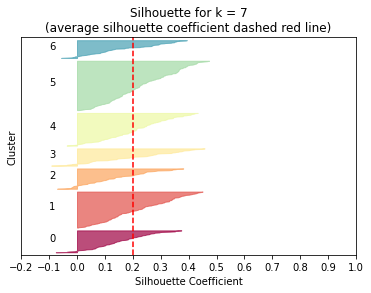

In [16]:
# Silhouette value calculation and plotting
"""
In the following code, the silhouette scores for *each* sample are calculated and plotted
# The silhouette value ranges from -1 to +1. A high silhouette value indicates that i is well-matched to its own cluster, 
    and poorly-matched to neighboring clusters. If most points have a high silhouette value, then the clustering 
    solution is appropriate.
"""

sample_silhouette_values = silhouette_samples(X, cluster_labels)
all_labels['Silhouette coefficient for k = ' + str(k)] = sample_silhouette_values

# Create a subplot with 1 row and 2 columns
mpl_fig = plt.figure()
ax1 = mpl_fig.add_subplot(111)
#fig, (ax1) = plt.subplots(1, 1)
#fig.set_size_inches(6, 4)

ax1.set_xlim([-0.2, 1])
# The (k+1)*10 is for inserting blank space between silhouette
# plots of individual clusters, to demarcate them clearly.
ax1.set_ylim([0, len(X) + (k + 1) * 10])

y_lower = 10
for i in range(k):
    # Aggregate the silhouette scores for samples belonging to
    # cluster i, and sort them
    ith_cluster_silhouette_values = \
        sample_silhouette_values[cluster_labels == i]

    ith_cluster_silhouette_values.sort()

    size_cluster_i = ith_cluster_silhouette_values.shape[0]
    y_upper = y_lower + size_cluster_i

    cmap = cm.get_cmap("Spectral")
    color = cmap(float(i) / k)
    ax1.fill_betweenx(np.arange(y_lower, y_upper),
                      0, ith_cluster_silhouette_values,
                      facecolor=color, edgecolor=color, alpha=0.7)

    # Label the silhouette plots with their cluster numbers at the middle
    ax1.text(-0.1, y_lower + 0.5 * size_cluster_i, str(i))

    # Compute the new y_lower for next plot
    y_lower = y_upper + 10  # 10 for the 0 samples

ax1.set_title("Silhouette for k = " + str(k) + "\n(average silhouette coefficient dashed red line)")
ax1.set_xlabel("Silhouette Coefficient")
ax1.set_ylabel("Cluster")

# The vertical line for average silhoutte score of all the values
ax1.axvline(x=silhouette_avg, color="red", linestyle="--")

ax1.set_yticks([])  # Clear the yaxis labels / ticks
ax1.set_xticks([-0.2, -0.1, 0, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1])

plt.show()

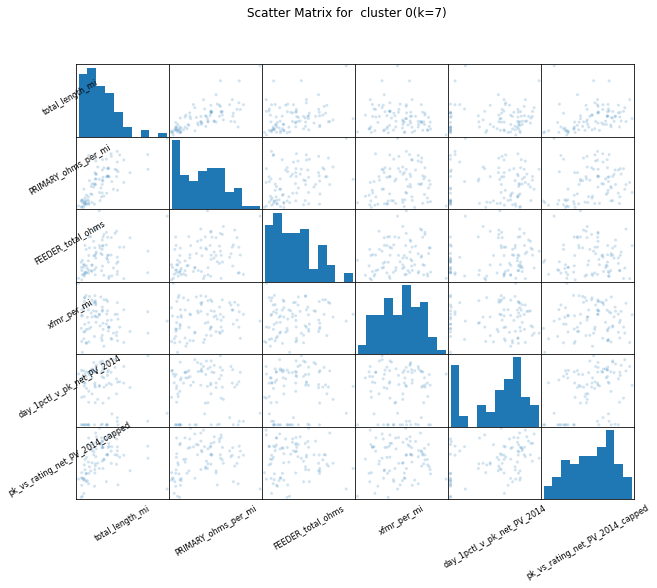

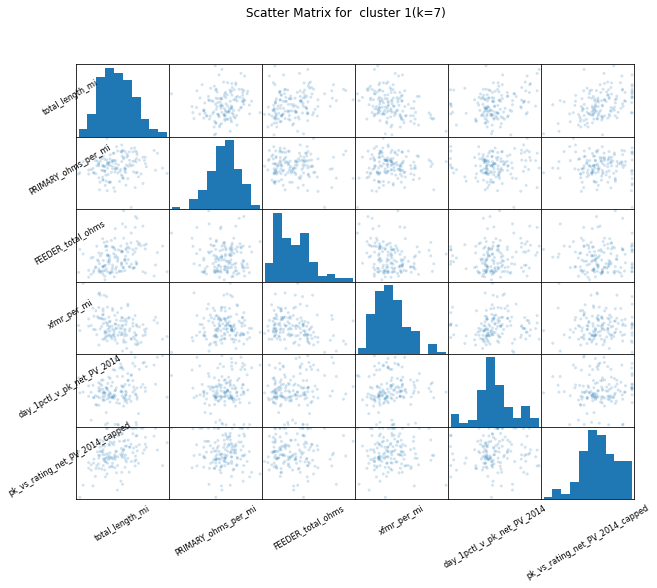

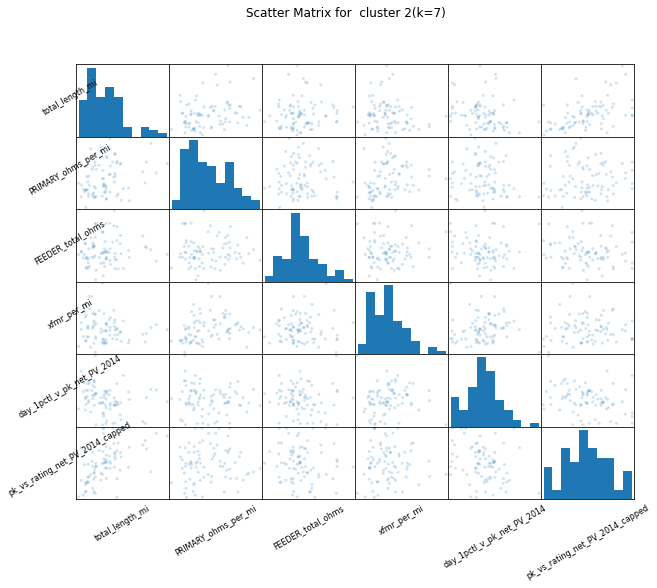

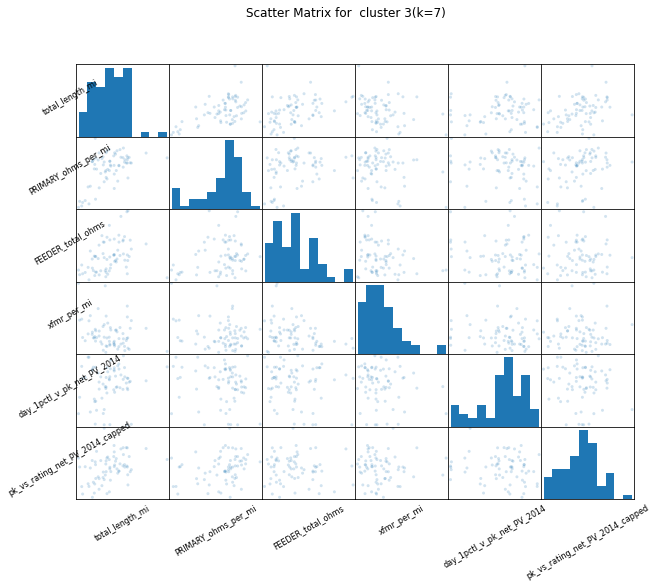

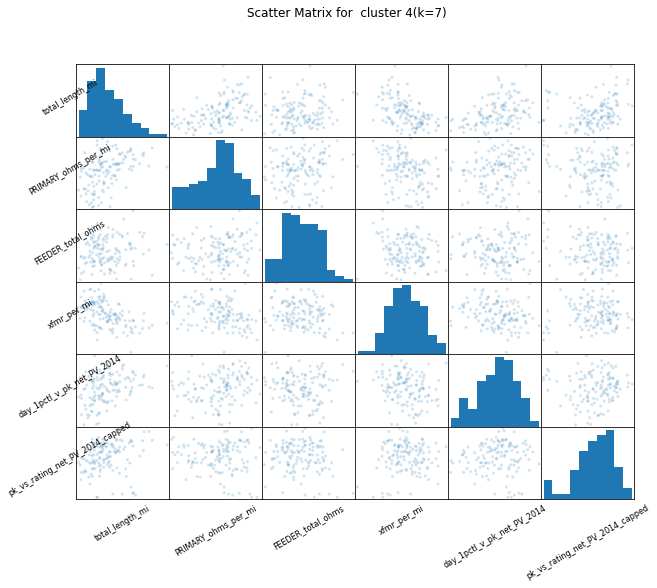

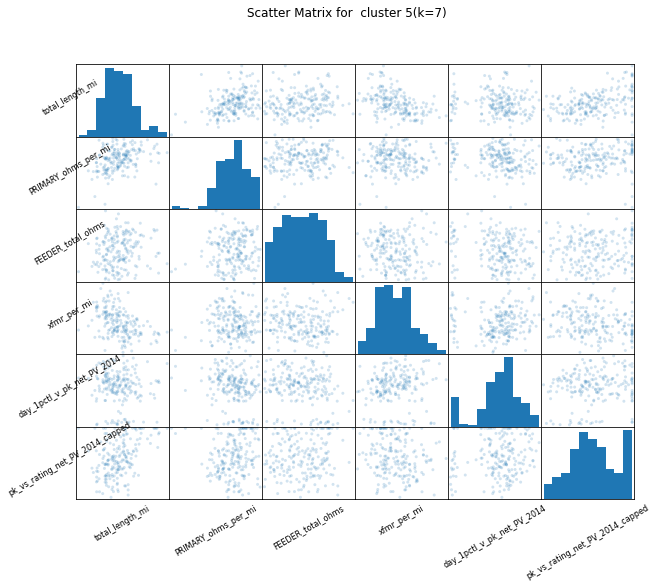

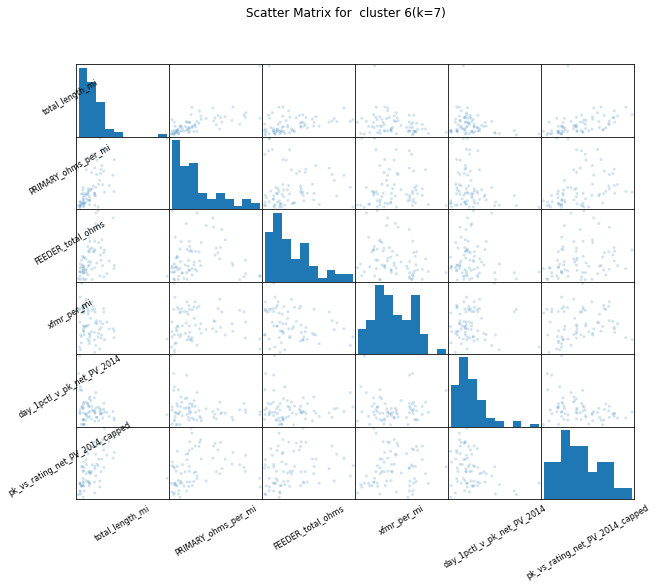

In [17]:
for cidx in range(0,k,1):
                        # plot = df.plot()
                        # fig = plot.get_figure()
    scatterplot = scatter_matrix(df[cluster_labels==cidx], alpha=0.2, figsize=(10, 8), diagonal='hist')
    fig = plt.gcf()
    for plot in range(0,len(scatterplot)):
        for subplot in range(0,len(scatterplot[plot]),1):
            ax = scatterplot[plot][subplot]
            ax.yaxis.label.set_rotation(30)
            ax.yaxis.label.set_size(8)
            ax.yaxis.set_ticks([])
            ax.xaxis.label.set_rotation(30)
            ax.xaxis.label.set_size(8)
            ax.xaxis.set_ticks([])
    fig.suptitle('Scatter Matrix for ' + ' cluster ' + str(cidx) + '(k=' + str(k) + ')')
    plt.show()